<a href="https://colab.research.google.com/github/Rishabh672003/Learning-machine-learning/blob/main/jupyter-notebooks/facial-emotion-recognition-Affectnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the data from Kaggle

### This requires an API token .json file from kaggle

### get it from going to https://www.kaggle.com/settings/account and clicking `create new token`

### Then place the token .json file in your google drive, and copy the location in `kaggle_creds_path` variable and command below it

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
kaggle_creds_path = "/content/drive/MyDrive/Kaggle/kaggle.json"
! cp /content/drive/MyDrive/Kaggle/kaggle.json .

In [3]:
! pip install kaggle --quiet

In [4]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [5]:
!kaggle datasets download -d noamsegal/affectnet-training-data

 98% 308M/314M [00:03<00:00, 170MB/s]
100% 314M/314M [00:03<00:00, 102MB/s]


In [6]:
import zipfile
import os
import shutil
location = '/content/affectnet-training-data'
zip_ref = zipfile.ZipFile(location+'.zip', 'r')

if os.path.isdir(location):
    shutil.rmtree(location)
    os.mkdir(location)
else:
    os.mkdir(location)

zip_ref.extractall(location)
zip_ref.close()

In [7]:
# Unmount your Google Drive
drive.flush_and_unmount()

# Actual Making the model

In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow import keras

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow.keras import layers, Sequential
from tensorflow.keras import losses

In [16]:
dataset_dir = os.path.join("/content/affectnet-training-data")
dataset_dir

'/content/affectnet-training-data'

In [17]:
os.listdir(dataset_dir)

['disgust',
 'neutral',
 'surprise',
 'fear',
 'happy',
 'contempt',
 'sad',
 'anger',
 'labels.csv']

In [18]:
len(os.listdir(dataset_dir + '/anger'))

3218

In [19]:
batch_size = 32
img_height = 96
img_width = 96

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 29042 files belonging to 8 classes.
Using 23234 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 29042 files belonging to 8 classes.
Using 5808 files for validation.


In [22]:
train_ds.element_spec, val_ds.element_spec

((TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

In [23]:
class_names = train_ds.class_names
print(class_names) # 8 classes

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


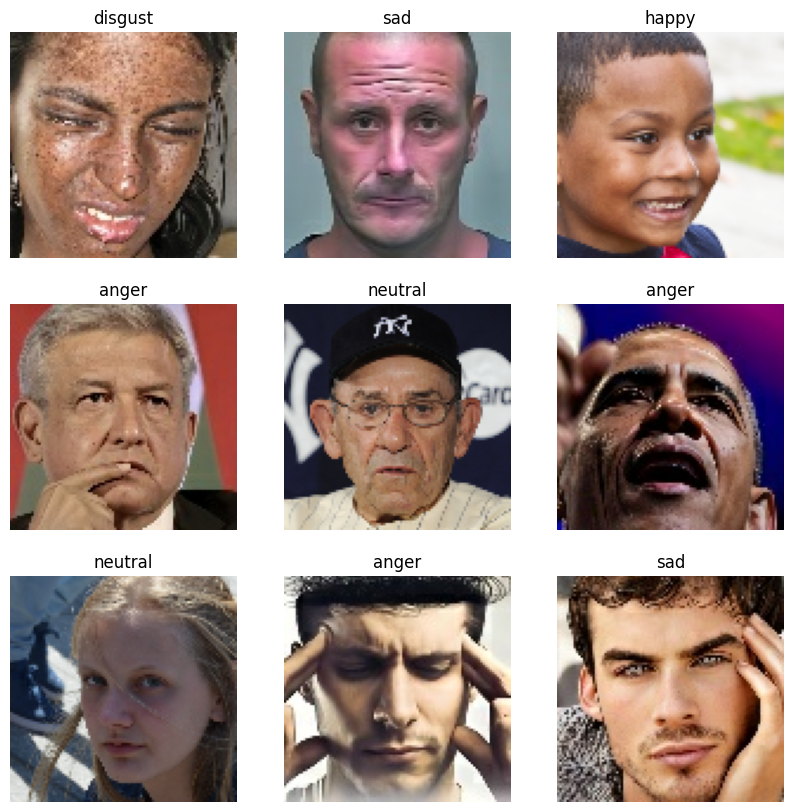

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [36]:
K = 8

## Implementing data augmentation

In [61]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

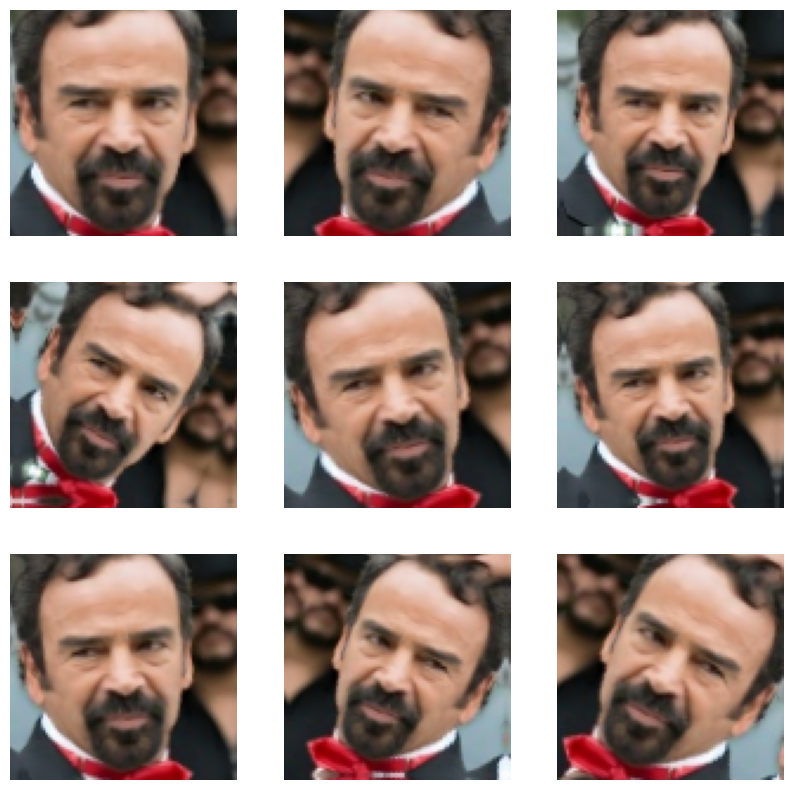

In [62]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Making the model

In [63]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 rescaling_7 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                

In [66]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose = 1, patience=2, restore_best_weights=True)
epochs=50
r = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/50
727/727 [==============================] - 10s 10ms/step - loss: 1.6016 - accuracy: 0.3516 - val_loss: 1.3547 - val_accuracy: 0.4568
Epoch 2/50
727/727 [==============================] - 8s 11ms/step - loss: 1.3673 - accuracy: 0.4599 - val_loss: 1.2370 - val_accuracy: 0.5129
Epoch 3/50
727/727 [==============================] - 7s 10ms/step - loss: 1.2772 - accuracy: 0.5009 - val_loss: 1.2044 - val_accuracy: 0.5301
Epoch 4/50
727/727 [==============================] - 8s 11ms/step - loss: 1.2248 - accuracy: 0.5264 - val_loss: 1.1515 - val_accuracy: 0.5504
Epoch 5/50
727/727 [==============================] - 7s 10ms/step - loss: 1.1760 - accuracy: 0.5458 - val_loss: 1.1623 - val_accuracy: 0.5522
Epoch 6/50
727/727 [==============================] - 9s 12ms/step - loss: 1.1476 - accuracy: 0.5596 - val_loss: 1.1203 - val_accuracy: 0.5597
Epoch 7/50
727/727 [==============================] - 8s 11ms/step - loss: 1.1163 - accuracy: 0.5740 - val_loss: 1.1139 - val_accuracy: 0.572

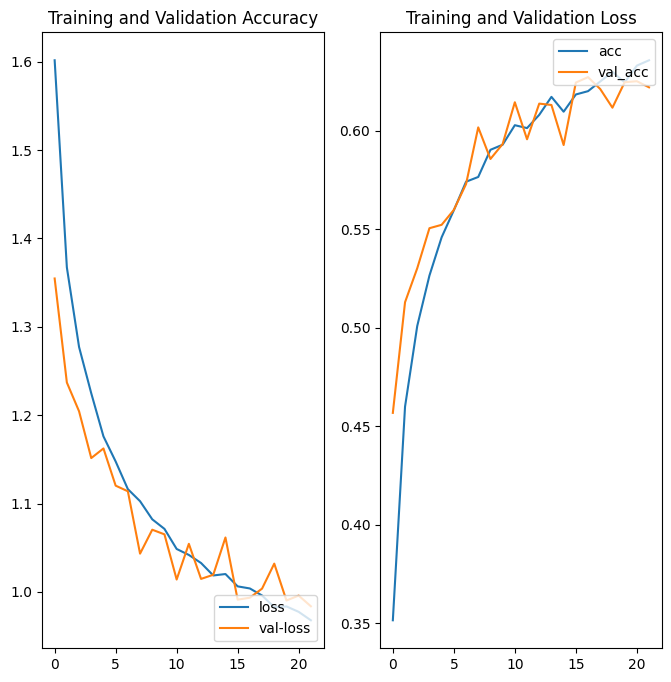

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val-loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
